In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [37]:
# This function parse the ouput of PerkinElmer 
# Scan Array CSV File to find the start and end 
# of the output table
# It also find the cyanine 5 channel (CH1, CH2 or CH3)
# that contains
# the SH2 domain reading 
def parse_text(start_line='BEGIN DATA', 
               out_file_path=''):
    a=0
    start = 0
    end = 0
    for l in open(out_file_path):
        a+=1
        if l.startswith(start_line):
            start += a
        if l.startswith('END DATA'):
            end += a
        if 'Cyanine 5' in l:
            ch = l.split(',')[1]
            ch = ch.replace('H','h')
    return start, end, ch

In [38]:
out_file_path = os.path.join('data_file_post','714-75_BRDG1.csv')
start, end , ch = parse_text(out_file_path=out_file_path)
print(start, end , ch)

71 19273 Ch1


In [39]:
#now we can read an output file
df = pd.read_table(out_file_path, sep=',',
                   skiprows=start, engine ='python', 
                   skipfooter=1)
df.head()

,Index,Array Row,Array Column,Spot Row,Spot Column,Name,ID,X,Y,Diameter,...,Ch1 SD,Ch1 B Median,Ch1 B Mean,Ch1 B SD,Ch1 % > B + 1 SD,Ch1 % > B + 2 SD,Ch1 F % Sat.,Ch1 Median - B,Ch1 Mean - B,Ch1 SignalNoiseRatio
0,1,1,1,1,1,GNEPDKYPCNGQV,>Part3-5146,2317,5407,200,...,16.24,114,113,12.96,22.7,6.6,0.0,0,0,8.80
1,2,1,1,1,2,NLSQGGYEELERV,>Part3-5151,2537,5413,200,...,17.16,117,120,16.02,18.8,6.3,0.0,1,2,7.36
2,3,1,1,1,3,ALAAEGYYDIRRV,>Part3-5166,2771,5414,200,...,17.78,114,117,15.29,34.0,16.1,0.0,8,10,7.98
3,4,1,1,1,4,QHDEPCYWRLTRV,>Part3-5187,2993,5411,200,...,18.60,124,126,21.20,17.5,0.4,0.0,-1,1,5.75
4,5,1,1,1,5,EAGKPIYSRYGSV,>Part3-5199,3203,5396,200,...,16.94,122,125,19.50,15.3,1.4,0.0,-1,0,6.15


In [40]:
df.columns

Index(['Index', 'Array Row', 'Array Column', 'Spot Row', 'Spot Column', 'Name',
       'ID', 'X', 'Y', 'Diameter', 'F Pixels', 'B Pixels', 'Footprint',
       'Flags', 'Ch1 Median', 'Ch1 Mean', 'Ch1 SD', 'Ch1 B Median',
       'Ch1 B Mean', 'Ch1 B SD', 'Ch1 % > B + 1 SD', 'Ch1 % > B + 2 SD',
       'Ch1 F % Sat.', 'Ch1 Median - B', 'Ch1 Mean - B',
       'Ch1 SignalNoiseRatio'],
      dtype='object')

In [41]:
res = []
for n in df['ID']:
    try:
        res.append(int(n.split('-')[1].split(' ')[0]))
    except:
        res.append(np.nan)
df['sub_ID'] = res

In [42]:
#df['sub_ID'].value_counts()

# The array is composed of 3 identical blocks 
of 6400 spots, So that each spot on the array is repeated 3 times. The spots contains peptides or a controls (dye, Marker, GST...). A peptide can be spotted multiple times on the same block to control for reproducibility. For example, the peptides RVKEEGYELPYNP and GEEEHVYSFPNKQ are spotted 3 times in different position of the block.

/Users/MTinti/miniconda3/envs/myEnv/lib/python3.7/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/MTinti/miniconda3/envs/myEnv/lib/python3.7/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/MTinti/miniconda3/envs/myEnv/lib/python3.7/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/MTinti/miniconda3/envs/myEnv

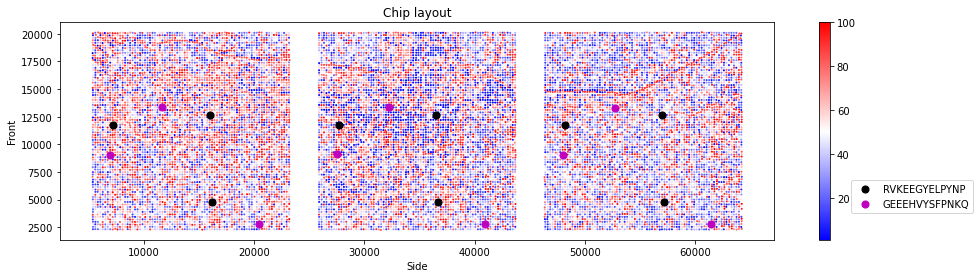

In [43]:
#create percentile of signal - background to color code intensity.
fig,ax=plt.subplots( figsize=(16,4),)
c= pd.qcut(df[ch+' Mean - B'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter',s=1,
       c=c, colormap='bwr',ax=ax)

df[df['Name']=='RVKEEGYELPYNP'].plot(x='Y', y='X',
                                     kind='scatter', s=50, c='k',ax=ax,label='RVKEEGYELPYNP')
df[df['Name']=='GEEEHVYSFPNKQ'].plot(x='Y', y='X',
                                     kind='scatter', s=50, c='m',ax=ax,label='GEEEHVYSFPNKQ')


plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
plt.show()

# We can also visualize the background
to show experimental artifacts with antibody binding

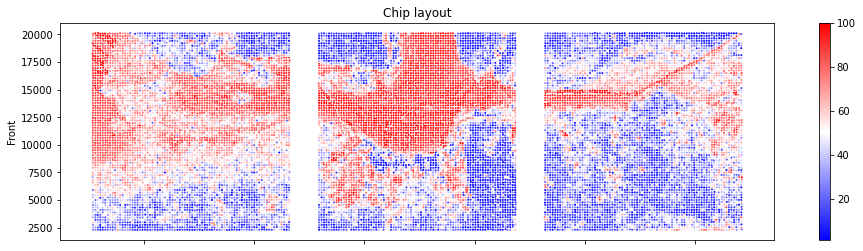

In [44]:
c= pd.qcut(df[ch+' B Median'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter', figsize=(16,4), s=1,
       c=c, colormap='bwr')
plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
plt.show()

# A problematic batch
anecdotally identified in the 714 chips, this batch is tagged Part3, with a number id greater than 4000.
This batch is responsible from some stripe patterns in the 714 chips

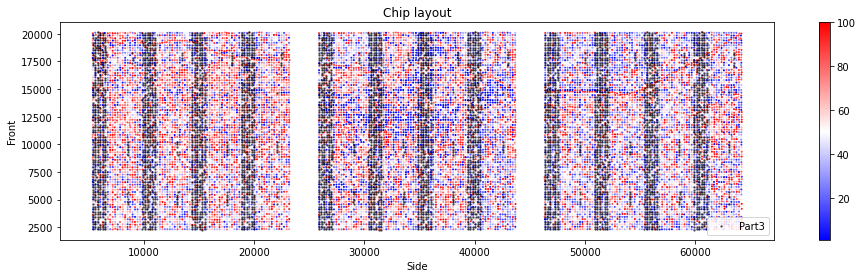

In [45]:
fig,ax=plt.subplots( figsize=(16,4),nrows=1,ncols=1)
c= pd.qcut(df[ch+' Mean - B'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter',s=1,
       c=c, colormap='bwr',ax=ax)

df[ df.ID.str.contains('Part3') & (df['sub_ID']>4000)  ].plot(x='Y', y='X',kind='scatter', s=2,
       c='k',alpha=0.5,ax=ax,label='Part3')

plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
plt.legend()
plt.show()

In [46]:
# These are probably the most useful columns
suffixes = [' Median',' Mean',' SD',' B Median',
         ' B Mean',' B SD',' % > B + 1 SD',' % > B + 2 SD',
         ' F % Sat.',' Median - B',' Mean - B',' SignalNoiseRatio']
# to wich we add the peptide sequence and batch identifier
cols = ['Name','ID']+[ch + n for n in suffixes]
df = df[cols]
df.head()

,Name,ID,Ch1 Median,Ch1 Mean,Ch1 SD,Ch1 B Median,Ch1 B Mean,Ch1 B SD,Ch1 % > B + 1 SD,Ch1 % > B + 2 SD,Ch1 F % Sat.,Ch1 Median - B,Ch1 Mean - B,Ch1 SignalNoiseRatio
0,GNEPDKYPCNGQV,>Part3-5146,114,114,16.24,114,113,12.96,22.7,6.6,0.0,0,0,8.80
1,NLSQGGYEELERV,>Part3-5151,118,119,17.16,117,120,16.02,18.8,6.3,0.0,1,2,7.36
2,ALAAEGYYDIRRV,>Part3-5166,122,124,17.78,114,117,15.29,34.0,16.1,0.0,8,10,7.98
3,QHDEPCYWRLTRV,>Part3-5187,122,125,18.60,124,126,21.20,17.5,0.4,0.0,-1,1,5.75
4,EAGKPIYSRYGSV,>Part3-5199,120,122,16.94,122,125,19.50,15.3,1.4,0.0,-1,0,6.15


In [47]:
#some spots contains markers
df['Name'].value_counts().head(10)

<<Marker>>       384
pY                72
Triple Flaq       12
TAMRA             12
GST               12
IgG               12
IgM               12
FITC              12
PKEDPIYDEPEGL      9
GTAEPDYGALYEG      9
Name: Name, dtype: int64

In [48]:
# the peptides in the array where sintetised in
# different batches
df['batch']=[n.split('-')[0] for n in df['ID']]
df.groupby('batch').size()

batch
5198_1       72
5804_1       12
5804_2       12
>Jerini     753
>Part1      492
>Part2      804
>Part3     9273
SH2          12
none       7770
dtype: int64

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
import logomaker as lm

# Compariso Chip signal - pepSpot db

## SignalNoiseRatio

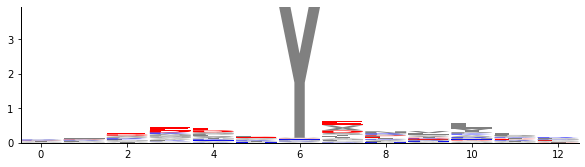

In [50]:
# The processing of the data is arbitray. I can suggest:
# Median of signal using the peptide sequences
# filter for 'Ch1 Median - B' > 0
temp = df.groupby('Name')[ch+' SignalNoiseRatio'].median().sort_values(ascending = False)
#get the top 500  
seqs = [n for n in list(temp.head(500).index.values) if len(n)==13 and 'Z' not in n]
# create counts matrix
'''
to_type: (str)
The type of matrix to output. Must be 'counts', 'probability',
'weight', or 'information'
'''
ww_counts_df = lm.alignment_to_matrix(sequences=seqs, 
                                      to_type='information',)
crp_logo=lm.Logo(ww_counts_df,color_scheme='charge')
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#plt.ylim(0,10)
plt.show()

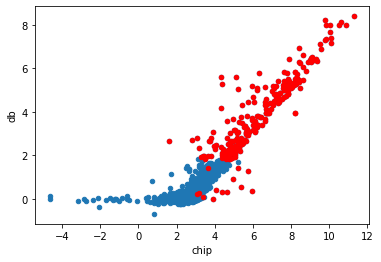

In [51]:
#

slide_data = df.groupby('Name')[ch+' SignalNoiseRatio'].median().sort_values(ascending = False)
slide_data=slide_data.to_frame()

db_data = pd.read_csv('SH2_all_logratio_values.csv',sep='\t')
db_data=db_data[['sequence','SH2_BRDG1_09-08-2006__714-75']]
db_data.set_index('sequence',inplace=True)



db_binders = pd.read_csv('SH2_all_logratio_binders.csv',sep='\t')
db_binders=db_binders[['sequence','SH2_BRDG1_09-08-2006__714-75']]
db_binders=db_binders[db_binders['SH2_BRDG1_09-08-2006__714-75']==2]
db_binders=list(db_binders['sequence'])


merge = slide_data.join(db_data)
merge.columns = ['chip','db']
merge['chip']=np.log2(merge['chip'])
fig,ax=plt.subplots()
merge.plot(kind='scatter',x='chip',y='db',ax=ax)
merge.loc[db_binders].plot(kind='scatter',x='chip',y='db',c='r',ax=ax)
plt.show()

##  Median - B

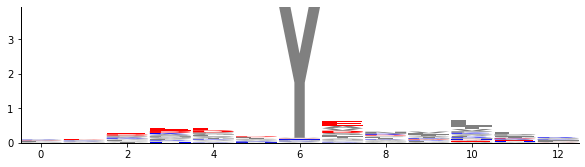

In [52]:
# The processing of the data is arbitray. I can suggest:
# Median of signal using the peptide sequences
# filter for 'Ch1 Median - B' > 0
temp = df.groupby('Name')[ch+' Median - B'].median().sort_values(ascending = False)
#get the top 500  
seqs = [n for n in list(temp.head(500).index.values) if len(n)==13 and 'Z' not in n]
# create counts matrix
'''
to_type: (str)
The type of matrix to output. Must be 'counts', 'probability',
'weight', or 'information'
'''
ww_counts_df = lm.alignment_to_matrix(sequences=seqs, 
                                      to_type='information',)
crp_logo=lm.Logo(ww_counts_df,color_scheme='charge')
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#plt.ylim(0,10)
plt.show()

/Users/MTinti/miniconda3/envs/myEnv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/Users/MTinti/miniconda3/envs/myEnv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log2
  # This is added back by InteractiveShellApp.init_path()


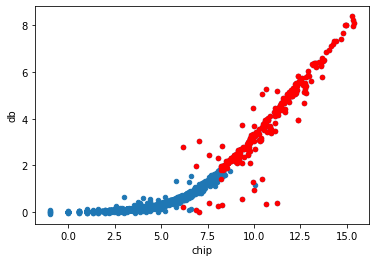

In [53]:
slide_data = df.groupby('Name')[ch+' Median - B'].median().sort_values(ascending = False)
slide_data=slide_data.to_frame()

db_data = pd.read_csv('SH2_all_logratio_values.csv',sep='\t')
db_data=db_data[['sequence','SH2_BRDG1_09-08-2006__714-75']]
db_data.set_index('sequence',inplace=True)
db_data.head()

merge = slide_data.join(db_data)
merge.columns = ['chip','db']
merge['chip']=np.log2(merge['chip'])
fig,ax=plt.subplots()
merge.plot(kind='scatter',x='chip',y='db',ax=ax)
merge.loc[db_binders].plot(kind='scatter',x='chip',y='db',c='r',ax=ax)

plt.show()

In [28]:
# The raw files starting with different 
# nubers have a different layout of the 
# blocks: 816 and 811 have same layout that differs from 714
fnames = []
for fname in os.listdir('data_file_post'):
    if fname.endswith('csv'):
        fnames.append(fname.split('-')[0])
print(set(fnames))

{'811', '714', '816'}
